# Experimentos y análisis


In [12]:
from matplotlib import pyplot as plt
import pandas as pd
import subprocess
import os

CPU_EXEC = "../build/src/MyProjectCPU"
CL_EXEC = "../build/src/cl/MyProjectCL"
CUDA_EXEC = "../build/src/cuda/MyProjectCUDA"

## Experimento 1
Variar el tamaño del arreglo con `block_size` y `grid_size` fijos

- Párametros:
    - $N$: De $2^5$ a $2^{20}$

In [13]:

current_path = os.getcwd()
block = 1024
grid = 8

for i in range(5, 21):
    size = 2**i
    print("Running for size", size)
    # do 10 runs for each size
    for _ in range(10):
        subprocess.run([CPU_EXEC, str(size), current_path + "/cpu.csv"], stdout=subprocess.DEVNULL)
        subprocess.run([CL_EXEC, str(size), str(block), str(grid*block), current_path + "/cl.csv"], stdout=subprocess.DEVNULL)
        subprocess.run([CUDA_EXEC, str(size), str(block), str(grid*block), current_path + "/cuda.csv"], stdout=subprocess.DEVNULL)

Running for size 32
Running for size 64
Running for size 128
Running for size 256
Running for size 512
Running for size 1024
Running for size 2048
Running for size 4096
Running for size 8192
Running for size 16384
Running for size 32768
Running for size 65536
Running for size 131072
Running for size 262144
Running for size 524288
Running for size 1048576


### Análisis

In [14]:
# read from csv and add correct columns
cpu = pd.read_csv("cpu.csv", header=None)
cl = pd.read_csv("cl.csv", header=None)
cuda = pd.read_csv("cuda.csv", header=None)

cpu.columns = ["size", "data creation time", "execution time", "total time"]
cl.columns = ["size", "local size", "global size", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]
cuda.columns = ["size", "block size", "grid size", "data creation time", "copy to device time", "execution time", "copy to host time", "total time"]

print("CPU")
print(cpu)
print("CL")
print(cl)
print("CUDA")
print(cuda)

CPU
        size  data creation time  execution time  total time
0         32                   1               0           1
1         32                   2               0           2
2         32                   1               0           1
3         32                   1               0           1
4         32                   2               0           2
..       ...                 ...             ...         ...
155  1048576               44917            4739       49656
156  1048576               45413            4702       50115
157  1048576               44555            4736       49291
158  1048576               44323            4684       49007
159  1048576               44749            4788       49537

[160 rows x 4 columns]
CL
        size  local size  global size  data creation time  \
0         32        1024         8192                   1   
1         32        1024         8192                   1   
2         32        1024         8192                 

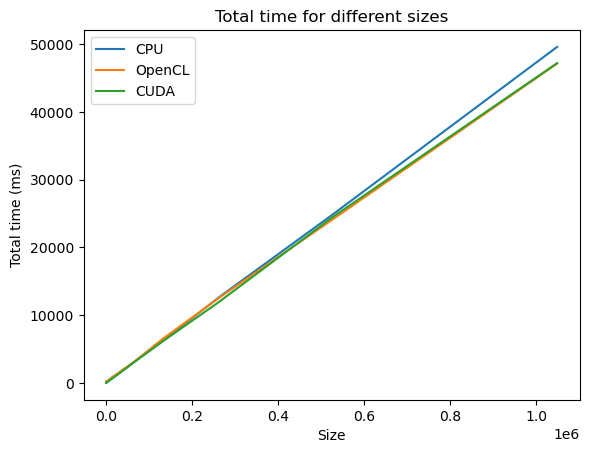

In [22]:
# plot avg total time for each size
cpu_avg = cpu.groupby("size").mean()
cl_avg = cl.groupby("size").mean()
cuda_avg = cuda.groupby("size").mean()

fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["total time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["total time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["total time"], label="CUDA")
ax.set_xlabel("Size")
ax.set_ylabel("Total time (ms)")
ax.legend()
plt.title("Total time for different sizes")
plt.show()

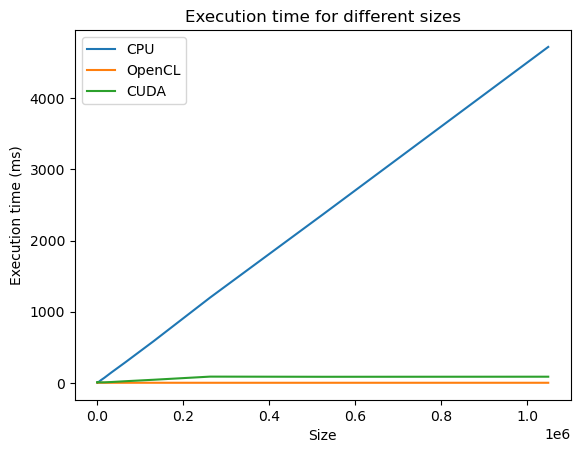

In [23]:
# plot avg execution time for each size
fig, ax = plt.subplots()
ax.plot(cpu_avg.index, cpu_avg["execution time"], label="CPU")
ax.plot(cl_avg.index, cl_avg["execution time"], label="OpenCL")
ax.plot(cuda_avg.index, cuda_avg["execution time"], label="CUDA")
ax.set_xlabel("Size")
ax.set_ylabel("Execution time (ms)")
ax.legend()
plt.title("Execution time for different sizes")
plt.show()

In [28]:
# print speedup on execution time
speedup_cl = cpu_avg["execution time"] / cl_avg["execution time"]
speedup_cuda = cpu_avg["execution time"] / cuda_avg["execution time"]

print("Speedup OpenCL")
print(speedup_cl)
print("Speedup CUDA")
print(speedup_cuda)

Speedup OpenCL
size
32            0.000000
64            0.000000
128           0.000000
256           0.500000
512           0.952381
1024          2.105263
2048          5.350000
4096          9.000000
8192         18.850000
16384        32.772727
32768        73.600000
65536       145.700000
131072      255.391304
262144      599.500000
524288     1183.400000
1048576    2248.761905
Name: execution time, dtype: float64
Speedup CUDA
size
32          0.000000
64          0.000000
128         0.000000
256         0.133333
512         0.273973
1024        0.476190
2048        1.337500
4096        2.222222
8192        4.833333
16384       8.901235
32768      11.590551
65536      12.141667
131072     13.200000
262144     13.532731
524288     27.425261
1048576    54.032037
Name: execution time, dtype: float64


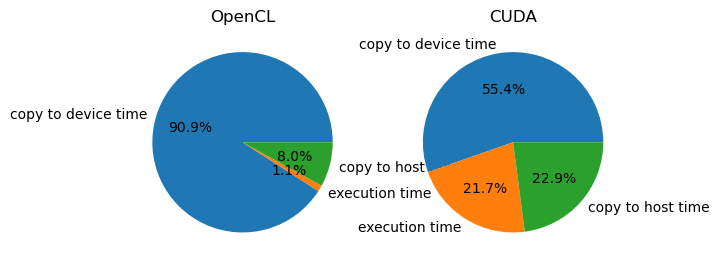

In [20]:
cl_avg["data creation time"] /= cl_avg.index
cl_avg["copy to device time"] /= cl_avg.index
cl_avg["execution time"] /= cl_avg.index
cl_avg["copy to host time"] /= cl_avg.index

cuda_avg["data creation time"] /= cuda_avg.index
cuda_avg["copy to device time"] /= cuda_avg.index
cuda_avg["execution time"] /= cuda_avg.index
cuda_avg["copy to host time"] /= cuda_avg.index

# plot a two pie chart of the average time spent on each step for OpenCL and CUDA
fig, ax = plt.subplots(1, 2)
ax[0].pie(cl_avg.iloc[0][3:6], labels=cl_avg.columns[3:6], autopct='%1.1f%%')
ax[0].set_title("OpenCL")
ax[1].pie(cuda_avg.iloc[0][3:6], labels=cuda_avg.columns[3:6], autopct='%1.1f%%')
ax[1].set_title("CUDA")
plt.show()



### Conclusión
- Para arreglos de tamaño menor o igual a $2^{20}$ el rendimiento en CPU y GPU es similar
- Existen un gran speedup en *tiempo de ejecución* no asi en *tiempo total* del programa
- En OpenCL el mayor problema esta en el paso de memoria de CPU a GPU.
- En CUDA también se repite este problema pero esta más equilibrado.